# マルチパスプランジェネレーター
* 『LangChainとLangGraphによるRAG・AIエージェント実践入門（12章より)』
* タスク分解時に複数の選択肢を同時に生成し、実行時のコンテキストに応じて実行エージェント自身に都度適切な選択をさせるパターン

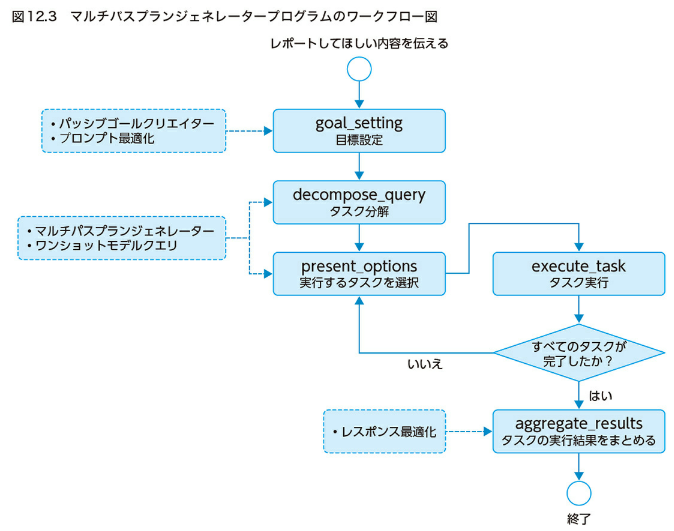

In [1]:
from IPython.display import Image
Image("/content/drive/MyDrive/for_study_in_library/study_LangGraph/png/mppg.png")

ここでは、シングルパスプランジェネレーター例のワークフローに、マルチパスプランジェネレーターにより生成された選択肢の中から適切なものを選択するための`present_options`ノードを追加。ここで選択されたタスクが、後続の`execute_task`ノードで実行される

In [1]:
# !pip install langchain-core==0.3.0 langchain-community==0.3.0 \
# langgraph==0.2.22 langchain-openai==0.2.0 langchain-anthropic==0.2.0 \
# numpy==1.26.4 faiss-cpu==1.8.0.post1 \
# pydantic-settings==2.5.2 retry==0.9.2 decorator==4.4.2

In [2]:
# !pip install "pydantic<2.11"  # 例: 2.10.6 エラー回避用

In [3]:
from dotenv import load_dotenv
load_dotenv()

In [4]:
# import os

# os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
# os.environ["LANGCHAIN_PROJECT"] = LANGCHAIN_PROJECT
# os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [5]:
import operator
from datetime import datetime
from typing import Annotated, Any

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import ConfigurableField
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import create_react_agent
from agent_tools.passive_goal_creator.main import Goal, PassiveGoalCreator
from agent_tools.prompt_optimizer.main import OptimizedGoal, PromptOptimizer
from pydantic import BaseModel, Field
from agent_tools.response_optimizer.main import ResponseOptimizer

from pprint import pprint

## ステート設計
タスクに複数の選択肢を保持させるため、新しく`DecomposedTasks`クラスをデータモデルとして定義

In [8]:
class TaskOption(BaseModel):
    description: str = Field(default="", description="タスクオプションの説明")


class Task(BaseModel):
    task_name: str = Field(..., description="タスクの名前")
    options: list[TaskOption] = Field(
        default_factory=list,
        min_items=2,
        max_items=3,
        description="2~3個のタスクオプション",
    )


class DecomposedTasks(BaseModel):
    values: list[Task] = Field(
        default_factory=list,
        min_items=3,
        max_items=5,
        description="3~5個に分解されたタスク",
    )


class MultiPathPlanGenerationState(BaseModel):
    query: str = Field(..., description="ユーザーが入力したクエリ")
    optimized_goal: str = Field(default="", description="最適化された目標")
    optimized_response: str = Field(default="", description="最適化されたレスポンス")
    tasks: DecomposedTasks = Field(
        default_factory=DecomposedTasks,
        description="複数のオプションを持つタスクのリスト",
    )
    current_task_index: int = Field(default=0, description="現在のタスクのインデックス")
    chosen_options: Annotated[list[int], operator.add] = Field(
        default_factory=list, description="各タスクで選択されたオプションのインデックス"
    )
    results: Annotated[list[str], operator.add] = Field(
        default_factory=list, description="実行されたタスクの結果"
    )
    final_output: str = Field(default="", description="最終出力")

AIエージェントによる選択をステートに保持するため、`chosen_options`フィールドに、各タスクで選択された選択肢のインデックスをリストで保持する仕様

## `decomposed_query`ノード

In [9]:
class QueryDecomposer:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm
        self.current_date = datetime.now().strftime("%Y-%m-%d")

    def run(self, query: str) -> DecomposedTasks:
        prompt = ChatPromptTemplate.from_template(
            f"CURRENT_DATE: {self.current_date}\n"
            "-----\n"
            "タスク: 与えられた目標を3〜5個の高レベルタスクに分解し、各タスクに2〜3個の具体的なオプションを提供してください。\n"
            "要件:\n"
            "1. 以下の行動だけで目標を達成すること。決して指定された以外の行動をとらないこと。\n"
            "   - インターネットを利用して、目標を達成するための調査を行う。\n"
            "2. 各高レベルタスクは具体的かつ詳細に記載されており、単独で実行ならびに検証可能な情報を含めること。一切抽象的な表現を含まないこと。\n"
            "3. 各項レベルタスクに2〜3個の異なるアプローチまたはオプションを提供すること。\n"
            "4. タスクは実行可能な順序でリスト化すること。\n"
            "5. タスクは日本語で出力すること。\n\n"
            "REMEMBER: 実行できないタスク、ならびに選択肢は絶対に作成しないでください。\n\n"
            "目標: {query}"
        )
        chain = prompt | self.llm.with_structured_output(DecomposedTasks)
        return chain.invoke({"query": query})

以下が、`decompose_query`ノードで、中で、`QueruyDecomposer`を読んでいる  

```python
def _decompose_query(self, state: MultiPathPlanGenerationState) -> dict[str, Any]:
    tasks = self.query_decomposer.run(query=state.optimised_goal)
    return {"tasks": tasks}
```

## `present_options`ノード：タスク選択
`decomposed_query`ノードで生成したタスク内の選択肢から、適切な選択肢を選択する役目  

```python
def _present_options(self, state: MultiPathGenerationState): -> dict[str, Any]:
    current_task = state.tasks.values[state.current_task_index]
    chosen_option = self.option_presenter.run(task=current_task)
    return {"chosen_options": [chosen_option]}

```

ノードでは、現在の処理対象なっているタスクを１件抽出し、選択肢の中から適切なものを選択する責務を持つ`OptionPresenter`クラスのrun関数に渡している

In [10]:
class OptionPresenter:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm.configurable_fields(
            max_tokens=ConfigurableField(id="max_tokens")
        )

    def run(self, task: Task) -> int:
        task_name = task.task_name
        options = task.options

        print(f"\nタスク: {task_name}")
        for i, option in enumerate(options):
            print(f"{i + 1}. {option.description}")

        choice_prompt = ChatPromptTemplate.from_template(
            "タスク: 与えられたタスクとオプションに基づいて、最適なオプションを選択してください。必ず番号のみで回答してください。\n\n"
            "なお、あなたは次の行動しかできません。\n"
            "- インターネットを利用して、目標を達成するための調査を行う。\n\n"
            "タスク: {task_name}\n"
            "オプション:\n{options_text}\n"
            "選択 (1-{num_options}): "
        )

        options_text = "\n".join(
            f"{i+1}. {option.description}" for i, option in enumerate(options)
        )
        chain = (
            choice_prompt
            | self.llm.with_config(configurable=dict(max_tokens=1))
            | StrOutputParser()
        )
        choice_str = chain.invoke(
            {
                "task_name": task_name,
                "options_text": options_text,
                "num_options": len(options),
            }
        )
        print(f"==> エージェントの選択: {choice_str}\n")

        return int(choice_str.strip()) - 1

## タスクの実行用

In [11]:
class TaskExecutor:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm
        self.tools = [TavilySearchResults(max_results=3)]

    def run(self, task: Task, chosen_option: TaskOption) -> str:
        agent = create_react_agent(self.llm, self.tools)
        result = agent.invoke(
            {
                "messages": [
                    (
                        "human",
                        f"以下のタスクを実行し、詳細な回答を提供してください:\n\n"
                        f"タスク: {task.task_name}\n"
                        f"選択されたアプローチ: {chosen_option.description}\n\n"
                        f"要件:\n"
                        f"1. 必要に応じて提供されたツールを使用すること。\n"
                        f"2. 実行において徹底的かつ包括的であること。\n"
                        f"3. 可能な限り具体的な事実やデータを提供すること。\n"
                        f"4. 発見事項を明確にまとめること。\n",
                    )
                ]
            }
        )
        return result["messages"][-1].content

## 結果集計用

In [12]:
class ResultAggregator:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm

    def run(
        self,
        query: str,
        response_definition: str,
        tasks: list[Task],
        chosen_options: list[int],
        results: list[str],
    ) -> str:
        prompt = ChatPromptTemplate.from_template(
            "与えられた目標:\n{query}\n\n"
            "調査結果:\n{task_results}\n\n"
            "与えられた目標に対し、調査結果を用いて、以下の指示に基づいてレスポンスを生成してください。\n"
            "{response_definition}"
        )
        task_results = self._format_task_results(tasks, chosen_options, results)
        chain = prompt | self.llm | StrOutputParser()
        return chain.invoke(
            {
                "query": query,
                "task_results": task_results,
                "response_definition": response_definition,
            }
        )

    @staticmethod
    def _format_task_results(
        tasks: list[Task], chosen_options: list[int], results: list[str]
    ) -> str:
        task_results = ""
        for i, (task, chosen_option, result) in enumerate(
            zip(tasks, chosen_options, results)
        ):
            task_name = task.task_name
            chosen_option_desc = task.options[chosen_option].description
            task_results += f"タスク {i+1}: {task_name}\n"
            task_results += f"選択されたアプローチ: {chosen_option_desc}\n"
            task_results += f"結果: {result}\n\n"
        return task_results

## グラフ作成、ノード登録、エッジ設定

In [13]:
class MultiPathPlanGeneration:
    def __init__(
        self,
        llm: ChatOpenAI,
    ):
        self.llm = llm
        self.passive_goal_creator = PassiveGoalCreator(llm=self.llm)
        self.prompt_optimizer = PromptOptimizer(llm=self.llm)
        self.response_optimizer = ResponseOptimizer(llm=self.llm)
        self.query_decomposer = QueryDecomposer(llm=self.llm)
        self.option_presenter = OptionPresenter(llm=self.llm)
        self.task_executor = TaskExecutor(llm=self.llm)
        self.result_aggregator = ResultAggregator(llm=self.llm)
        self.graph = self._create_graph()

    def _create_graph(self) -> StateGraph:
        graph = StateGraph(MultiPathPlanGenerationState)
        graph.add_node("goal_setting", self._goal_setting)
        graph.add_node("decompose_query", self._decompose_query)
        graph.add_node("present_options", self._present_options)
        graph.add_node("execute_task", self._execute_task)
        graph.add_node("aggregate_results", self._aggregate_results)
        graph.set_entry_point("goal_setting")
        graph.add_edge("goal_setting", "decompose_query")
        graph.add_edge("decompose_query", "present_options")
        graph.add_edge("present_options", "execute_task")
        graph.add_conditional_edges(
            "execute_task",
            lambda state: state.current_task_index < len(state.tasks.values),
            {True: "present_options", False: "aggregate_results"},
        )
        graph.add_edge("aggregate_results", END)

        return graph.compile()

    def _goal_setting(self, state: MultiPathPlanGenerationState) -> dict[str, Any]:
        # プロンプト最適化
        goal: Goal = self.passive_goal_creator.run(query=state.query)
        optimized_goal: OptimizedGoal = self.prompt_optimizer.run(query=goal.text)
        # レスポンス最適化
        optimized_response: str = self.response_optimizer.run(query=optimized_goal.text)
        return {
            "optimized_goal": optimized_goal.text,
            "optimized_response": optimized_response,
        }

    def _decompose_query(self, state: MultiPathPlanGenerationState) -> dict[str, Any]:
        tasks = self.query_decomposer.run(query=state.optimized_goal)
        return {"tasks": tasks}

    def _present_options(self, state: MultiPathPlanGenerationState) -> dict[str, Any]:
        current_task = state.tasks.values[state.current_task_index]
        chosen_option = self.option_presenter.run(task=current_task)
        return {"chosen_options": [chosen_option]}

    def _execute_task(self, state: MultiPathPlanGenerationState) -> dict[str, Any]:
        current_task = state.tasks.values[state.current_task_index]
        chosen_option = current_task.options[state.chosen_options[-1]]
        result = self.task_executor.run(
            task=current_task,
            chosen_option=chosen_option,
        )
        return {
            "results": [result],
            "current_task_index": state.current_task_index + 1,
        }

    def _aggregate_results(self, state: MultiPathPlanGenerationState) -> dict[str, Any]:
        final_output = self.result_aggregator.run(
            query=state.optimized_goal,
            response_definition=state.optimized_response,
            tasks=state.tasks.values,
            chosen_options=state.chosen_options,
            results=state.results,
        )
        return {"final_output": final_output}

    def run(self, query: str) -> str:
        initial_state = MultiPathPlanGenerationState(query=query)
        final_state = self.graph.invoke(initial_state, {"recursion_limit": 1000})

        # debug用
        print("ステートの中身：")
        pprint(dict(final_state))
        print("\n\n")

        return final_state.get("final_output", "最終的な回答の生成に失敗しました。")

## 実行

In [15]:
query = "カレーライスの作り方"

llm = ChatOpenAI(model="gpt-4o", temperature=0.0)

agent = MultiPathPlanGeneration(llm=llm)
result = agent.run(query=query)

print("\n\n=== 最終出力 ===")
pprint(result)


タスク: カレーライスの基本的なレシピを調査する
1. Googleで「カレーライス レシピ 基本」と検索し、上位3つのレシピサイトを確認する。
2. クックパッドで「カレーライス 基本レシピ」を検索し、評価の高いレシピを2つ選ぶ。
==> エージェントの選択: 1


タスク: 必要な材料とその分量を確認する
1. 選んだレシピサイトで材料リストを確認し、共通する材料をリストアップする。
2. クックパッドのレシピから材料とその分量を確認し、メモを取る。
==> エージェントの選択: 2


タスク: カレーライスの調理手順を調査する
1. 選んだレシピサイトで調理手順を確認し、手順を5ステップ以上にまとめる。
2. クックパッドのレシピから調理手順を確認し、手順を5ステップ以上にまとめる。
==> エージェントの選択: 2


タスク: 調査した情報をもとにレポートを作成する
1. 調査したレシピと手順をもとに、カレーライスの作り方を詳細に記載したレポートを作成する。
2. 材料、分量、手順を含むカレーライスの作り方をまとめたレポートを作成する。
==> エージェントの選択: 2


タスク: レポートの内容を確認し、必要に応じて修正する
1. レポートの内容を再度確認し、手順が5ステップ以上含まれているかをチェックする。
2. レポートを第三者に確認してもらい、フィードバックをもとに修正する。
==> エージェントの選択: 2

ステートの中身：
{'chosen_options': [0, 1, 1, 1, 1],
 'current_task_index': 5,
 'final_output': '以下に、カレーライスを作るための具体的な手順を親しみやすく、明確で簡潔なトーンで説明します。\n'
                 '\n'
                 '### 材料（4人分）\n'
                 '- カレールー: 100g（例: ゴールデンカレー中辛）\n'
                 '- 玉ねぎ: 1/2玉\n'
                 '- 人参: 1本\n'
                 '- じゃがいも: 2個\n'
                 '- 豚バラ肉: 150g\

# `min_items`, `max_items`設定について

最初に結論 — \*\*`min_items` と `max_items` は「そのフィールドが **`list` 型** のとき、要素数の下限・上限をバリデーションするための `Field` オプション」\*\*です。
Pydantic はモデル生成時に

1. 入力リストの長さをチェックし、
2. 違反していれば `ValidationError` を即座に投げ、
3. さらに JSON Schema を発行するときは `minItems` / `maxItems` プロパティとして書き出します。
   今回の例では LLM が 6 個のタスクを返したため、`max_items=5` の制約に違反し例外が発生しました。([docs.pydantic.dev][1], [docs.pydantic.dev][2])

---

## 1  Pydantic `Field` における `min_items` / `max_items`

| オプション                 | 適用対象                   | 動作                            | JSON Schema でのキー |
| --------------------- | ---------------------- | ----------------------------- | ---------------- |
| **`min_items=<int>`** | `list`, `set`, `tuple` | 要素数が設定値未満なら `ValidationError` | `minItems`       |
| **`max_items=<int>`** | 同上                     | 要素数が設定値より多いとエラー               | `maxItems`       |

> *公式ドキュメント*: “`min_items` / `max_items` は list 値に対しバリデーションと `minItems` / `maxItems` アノテーションを追加する” ([docs.pydantic.dev][2])

### サンプル

```python
from pydantic import BaseModel, Field

class ShoppingList(BaseModel):
    items: list[str] = Field(min_items=1, max_items=5)

ShoppingList(items=["milk"])               # ✅
ShoppingList(items=[])                     # ❌ min_items で失敗
ShoppingList(items=list("abcdef"))         # ❌ max_items で失敗
```

実行すると違反ケースでは `pydantic.ValidationError` が詳細メッセージ付きで上がります。([stackoverflow.com][3])

---

## 2  本コードに当てはめると

### 2.1 `Task.options`

```python
options: list[TaskOption] = Field(
    default_factory=list, min_items=2, max_items=3,
)
```

* 各タスクは **必ず 2〜3 個の選択肢** を持つ。
* 1 個だけ返ってきたり 4 個以上返ってくると検証エラー。

### 2.2 `DecomposedTasks.values`

```python
values: list[Task] = Field(
    default_factory=list, min_items=3, max_items=5,
)
```

* 高レベルタスクは **3〜5 個** に制限。
* ChatGPT が 6 個生成 → `ValidationError: List should have at most 5 items` が発生。

---

## 3  LangChain / LLM との相互作用

1. `query_decomposer.run()` では

   ```python
   self.llm.with_structured_output(DecomposedTasks)
   ```

   を使い Function-Calling で LLM に **「この JSON スキーマを満たす出力を返して」** と要求します。
2. Pydantic が提示したスキーマには `minItems=3/5` が含まれるため、モデルは「5 個以内」が望ましいと推測します。
3. それでも規則を破った場合、LangChain は応答 JSON を Pydantic に食わせ、**即 `ValidationError`** → 呼び出し側に例外が返る流れです。([github.com][4], [docs.pydantic.dev][1])

---

## 4  制約に違反した際の対策

* **LLM プロンプトを強める**
  “必ず 5 個以内” と明示、あるいは温度を下げる
* **`max_items` を緩める / 削除する**
  後段で `tasks[:5]` に切り詰める運用も可
* **例外を捕捉して自前で調整**

  ```python
  try:
      tasks = self.query_decomposer.run(...)
  except ValidationError as e:
      raw = e.errors()[0]["input_value"]
      tasks = DecomposedTasks(values=raw[:5])  # 先頭5件で強制成形
  ```

---

## 5  まとめ

* `min_items` / `max_items` は **list フィールドの要素数を静的に制限**する `Field` オプション。
* モデル生成時に Pydantic が検証を行い、違反すれば `ValidationError`。
* JSON Schema にも `minItems` / `maxItems` が出力され、Function-Calling による LLM の構造化出力で「仕様書」的役割を果たす。
* 制約を守らなかった場合は **プロンプト調整 or スキーマ緩和 or 例外で補正** のいずれかが実務上の解決策となります。

[1]: https://docs.pydantic.dev/1.10/usage/types/?utm_source=chatgpt.com "Field Types - Pydantic"
[2]: https://docs.pydantic.dev/1.10/usage/schema/?utm_source=chatgpt.com "Schema - Pydantic"
[3]: https://stackoverflow.com/questions/67800698/is-it-possible-to-impose-the-length-for-a-list-attribute-of-the-request-body-wit?utm_source=chatgpt.com "pydantic - Is it possible to impose the length for a list attribute of the ..."
[4]: https://github.com/pydantic/pydantic/issues/5405?utm_source=chatgpt.com "min_items error in Pydantic v2 · Issue #5405 - GitHub"
